#Тематическая модель на данных Last.fm

###Данные

Данные Last.fm брались <a href=http:/www.dtic.upf.edu/~ocelma/MusicRecommendationDataset/lastfm-360K.html> отсюда</a>. Они содержат плейлисты 360 тысяч пользователей с указанием сколько раз каждый юзер слушал музыканта. Эти плейлисты рассматривались как документы в тематической модели, и выделенные темы образовывали различные музыкальные жанры (названия которых я оставлю подобрать читателю).

###Процесс

Подключаем все необходимые библиотеки.

In [1]:
from lastfm_util import *
import matplotlib.pyplot as plt

import artm.artm_model
from artm.artm_model import *

%matplotlib inline

plays_file = 'usersha1-artmbid-artname-plays.tsv' #Название файла с данными

Теперь надо распарсить коллекцию и подать ее библиотеке. Я использовал свой парсер и создавал вручную батчи в нужном формате.

In [2]:
batch_path, dictionary_path = create_batches(users_to_handle = 5000, users_in_batch = 1000) 
#Мы обрабатываем только первые 100 тысяч записей и строим батчи по 1000 штук юзеров в каждом

Следующий шаг - настоить и запустить bigartm.

Создаем названия главных и фоновых тем, потом настраиваем регуляризаторы и счетчики.

In [3]:
all_topics, objective_topics, background_topics = create_topic_names(200, 5)

model = ArtmModel(topic_names=all_topics)
model.num_processors = 4

#Счетчики
model.scores.add(SparsityPhiScore(name='ObjectiveSparsityPhiScore', topic_names=objective_topics))
model.scores.add(SparsityThetaScore(name='ObjectiveSparsityThetaScore', topic_names=objective_topics))
model.scores.add(PerplexityScore(name='PerplexityScore'))
model.scores.add(TopTokensScore(name='TopTokensScore', num_tokens=5))
model.scores.add(TopTokensScore(name='TopTokensScoreExtended', num_tokens=20))

#Регуляризаторы
model.regularizers.add(SmoothSparsePhiRegularizer(name='ObjectiveSparsePhi',
                                                  topic_names=objective_topics, tau=-0.1))
model.regularizers.add(SmoothSparseThetaRegularizer(name='ObjectiveSparseTheta',
                                                    topic_names=objective_topics, tau=-2.0))
model.regularizers.add(SmoothSparsePhiRegularizer(name='BackgroundSparsePhi',
                                                  topic_names=background_topics, tau=0.1))
model.regularizers.add(SmoothSparseThetaRegularizer(name='BackgroundSparseTheta',
                                                    topic_names=background_topics, tau=2.0))
model.regularizers.add(DecorrelatorPhiRegularizer(name='DecorrelatorPhi',
                                                  topic_names=objective_topics, tau=100000.0))

model.initialize(data_path=batch_path)

Запускаем!

In [4]:
model.fit_offline(data_path=batch_path, num_collection_passes=15)

###Результаты

Теперь уже можно порисовать графики и вывести жанры. 

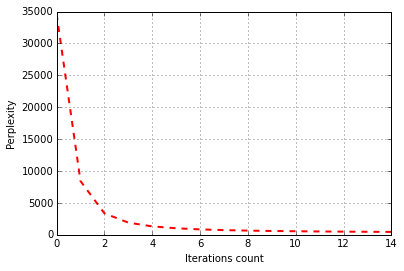

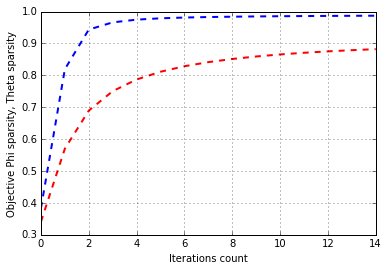

In [5]:
plt.plot(range(model.num_phi_updates), model.scores_info['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

plt.plot(range(model.num_phi_updates), model.scores_info['ObjectiveSparsityPhiScore'].value, 'b--',
         range(model.num_phi_updates), model.scores_info['ObjectiveSparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Objective Phi sparsity, Theta sparsity')
plt.grid(True)
plt.show()

In [16]:
print_genres(model, objective_topics, background_topics)

Genres
objective topic 0:  [u'kate nash', u'tellison', u'those dancing days', u'lykke li', u'mystery jets']
objective topic 1:  [u'phil ochs', u'the string quartet', u'crosby, stills, nash & young', u'david archuleta', u'hercules and love affair']
objective topic 2:  [u'kiuas', u'\u0410\u0440\u0434\u0430', u'scartown', u'osi', u'disarmonia mundi']
objective topic 3:  [u'ufo', u'phil ochs', u'the string quartet', u'crosby, stills, nash & young', u'david archuleta']
objective topic 4:  [u'phil ochs', u'the string quartet', u'crosby, stills, nash & young', u'david archuleta', u'hercules and love affair']
objective topic 5:  [u'phil ochs', u'the string quartet', u'crosby, stills, nash & young', u'david archuleta', u'hercules and love affair']
objective topic 6:  [u'phil ochs', u'the string quartet', u'crosby, stills, nash & young', u'david archuleta', u'hercules and love affair']
objective topic 7:  [u'phil ochs', u'the string quartet', u'crosby, stills, nash & young', u'david archuleta', 

Дальше мы можем по этой тематической модели искать похожих артистов и давать рекомендации пользователям.

Например, найдем похожих артистов для Metallica, Green day и Beatles. 

In [17]:
print "Mettalica"
for musician in find_similar_musicians(model, "metallica", 5, objective_topics):
    print musician[0], musician[1]
print "Green day"
for musician in find_similar_musicians(model, "green day", 5, objective_topics):
    print musician[0], musician[1]
print "Beatles"
for musician in find_similar_musicians(model, "the beatles", 5, objective_topics):
    print musician[0], musician[1]

Mettalica
Green day
Beatles


In [8]:
def print_user_info(user_id, top_musicians_count):
    for match in sorted([(match[1], match[0]) for match in users[user_id].items()], reverse=True)[:top_musicians_count]:
        print match[0], match[1]
    
def recommend_musicians(model, user_id, top_musicians_count, objective_topics):
    top_matches = {}
    
    user_topic = users[user_id]

    for topic in objective_topics:
        topic_musicians = model.scores_info['TopTokensScoreExtended'].last_topic_info[topic].tokens
        topic_weights = model.scores_info['TopTokensScoreExtended'].last_topic_info[topic].weights
        
        user_score = 0
        for musician in topic_musicians:
            if musician in user_topic:
                user_score += user_topic[musician] * topic_weights[topic_musicians.index(musician)]
        
        for musician in topic_musicians:
            if musician not in user_topic:
                if musician in top_matches:
                    top_matches[musician] += user_score * topic_weights[topic_musicians.index(musician)]
                else:
                    top_matches[musician] = user_score * topic_weights[topic_musicians.index(musician)]

    return sorted([(match[1], match[0]) for match in top_matches.items()], reverse=True)[:top_musicians_count]

user_id = "000710d4dff11af267edd2f70bf54e7678bdd729"
print "User's top musicians"
print_user_info(user_id, 5)
    
print

print "Recommendations"
for musician in recommend_musicians(model, user_id, 5, objective_topics):
    print musician[0], musician[1]


User's top musicians
0.0837137118861 radiohead
0.0588825999635 the knife
0.0555048384152 the hives
0.0298521088187 yeah yeah yeahs
0.026839510681 phoenix

Recommendations
0.00305446515099 sigur rós
0.00123349494476 muse
0.00122201632214 björk
0.00109000139401 blur
0.000938436419917 tool


In [6]:
import visualization_ldavis as visualization
visualizer = visualization.ArtmModelVisualizer(model, dictionary_path=dictionary_path)
visualizer